# 4 OAD updates

In this project,
we seek to optimize an aircraft of approximately 150 passengers that flies at Mach 0.78,
using different engine and fuel technologies.

## The OAD problem

The OAD problem is to find the values of the design parameters 
that minimize the maximum take-off mass (MTOM, `mtom` in the code) under some operation constraints.
Note that the MTOM of an airplane is a good criterion to optimize the design.
Alternative objectives are the cash operating cost (COC, `coc` in the code) or the direct operating cost (DOC, `doc` in the code).

### The design parameters

The **design parameters** are :

- the maximum sea level static thrust  (100 kN ≤ slst ≤ 200 kN, default: 150 kN),
- the number of passengers  (120 ≤ n_pax ≤ 180, default: 150),
- the wing area (100 m² ≤ area ≤ 200 m², default: 180 m²),
- the wing aspect ratio  (5 ≤ ar ≤ 20, default: 9.).

### The operational constraints

The **operational constraints** are :

- the take-off field length (tofl ≤ 1900 m),
- the approach speed (vapp ≤ 135 kt),
- the vertical speed (300 ft/min ≤ vz),
- the wing span (span ≤ 40 m),
- the wing length (length ≤ 45 m),
- the fuel margin (0% ≤ fm).

## The uncertain parameters

In Problems 2 and 3,
some parameters are considered as uncertain.

These uncertain parameters are modelled as random variables defined by probability distributions:

| Variable | Distribution          | Fuel type | Engine type |
|----------|-----------------------|-----------|-------------|
| `gi`     | T(0.35, 0.4, 0.405)   | liquid_h2 | All         |
| `vi`     | T(0.755, 0.800, 0805) | liquid_h2 | All         |
| `aef`    | T(0.99, 1., 1.03)     | All       | All         |
| `cef`    | T(0.99, 1., 1.03)     | All       | All         |
| `aef`    | T(0.99, 1., 1.03)     | All       | All         |
| `fc_pwd` | T(0.8, 1, 1.02)       | liquid_h2 | electrofan  |
| `bed`    | U(400,700)            | battery   | All         |

where `T(minimum, mode, maximum)` and `U(minimum,maximum)`
represent the [triangular distribution](https://en.wikipedia.org/wiki/Triangular_distribution)
and the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) respectively.
the last two columns indicate the type of fuel and the type of engine
for which these uncertain parameters are relevant.

The parameters `aef`, `cef` and `aef` are related
to the three main technical areas involved in aircraft design,
namely aerodynamics, propulsion and structure.
The lower, the better.
These factors are representing the unknown
included in any creative activity.
Their probability distributions are not symmetrical
as it is always easier to make something less efficient than expected...

## The 12 models

The 12 models are defined in `gemseo-oad` as Python functions:



In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo import configure_logger

configure_logger()

<RootLogger root (INFO)>

## Problème 1 - Modélisation par surrogate et optimisation

Nous allons créer un modèle de substitution (surrogate model) noté :

$$
\hat{f} : x \mapsto \hat{f}(x) = f(x, u_{\mathrm{default}})
$$

Ce modèle approxime la fonction objectif ainsi que les contraintes du problème de conception, en fonction des paramètres de conception \(x\), avec les conditions d'utilisation fixées à $u_{\mathrm{default}}$.

Une fois ce modèle construit, nous l'utiliserons dans un processus d'optimisation pour :

- **Minimiser** la fonction objectif,
- **Respecter** les contraintes imposées,

en faisant varier les paramètres de conception \(x\).



## The units

The use cases are written using common units.

The models only know STANDARD UNITS which means
that all data provided to the function MUST be expressed in standard units
and that all data retrieved by the function are expressed in standard units.

!!! tip "Convert units"
    The functions `convert_from` and `convert_to` from `gemseo_oad_training.unit` can make the conversion easier.

## The four use cases

| Id  | Fuel type | Engine type | Design range (km) |
|-----|-----------|-------------|-------------------|
| UC1 | Kerosene  | Turbofan    | 5500              |
| UC2 | Hydrogen  | Turbofan    | 5500              |
| UC3 | Hydrogen  | Electrofan  | 5500              |
| UC4 | Battery   | Electrofan  | 500               |

In [3]:
# On veut résoudre le problème 1 avec UC1 et UC2
from gemseo.disciplines.auto_py import AutoPyDiscipline

disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [4]:
# Create the design space
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from

design_space = DesignSpace()

design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [5]:
# Add the constraints
from gemseo.scenarios.mdo_scenario import MDOScenario
scenario = MDOScenario(disciplines=disciplines, design_space=design_space, objective_name= "mtom",formulation_name='MDF')
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True)

In [27]:
from gemseo import sample_disciplines
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.disciplines.surrogate import SurrogateDiscipline
from numpy import array

training_dataset = sample_disciplines(disciplines, design_space, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

test_dataset = sample_disciplines(disciplines, design_space, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_FULLFACT", n_samples=20)

    INFO - 15:33:20: *** Start Sampling execution ***
    INFO - 15:33:20: Sampling
    INFO - 15:33:20:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:33:20:    MDO formulation: MDF
    INFO - 15:33:20: Running the algorithm OT_OPT_LHS:
    INFO - 15:33:20:    100%|██████████| 20/20 [00:00<00:00, 70.37 it/sec]
    INFO - 15:33:20: *** End Sampling execution (time: 0:00:00.295900) ***
    INFO - 15:33:20: *** Start Sampling execution ***
    INFO - 15:33:20: Sampling
    INFO - 15:33:20:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:33:20:    MDO formulation: MDF
    INFO - 15:33:20: Running the algorithm OT_FULLFACT:
    INFO - 15:33:20:    100%|██████████| 16/16 [00:00<00:00, 70.34 it/sec]s not exist; use 16 samples instead, i.e. the largest 4-th integer power less than 20.
    INFO - 15:33:20: *** End

 Testing surrogate: RBF_gaussian_5
 Testing surrogate: RBF_gaussian_2
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg2

Résultats comparatifs :
                     fm  length    mtom    span    tofl    vapp      vz
Model                                                                  
RBF_gaussian_5   0.9922  0.9991  0.9669  0.9970  0.9481  0.9960  0.9721
RBF_gaussian_2   0.9698  0.9723  0.9548  0.9750  0.8798  0.9796  0.9530
RBF_gaussian_mg  0.9938  0.9998  0.9663  0.9978  0.9624  0.9970  0.9726
Polynomial_deg2  0.9950  1.0000  0.9698  0.9985  0.9586  0.9965  0.9775
Polynomial_deg2  0.9924  0.9979  0.9309  0.9931  0.8787  0.9731  0.9432


<Figure size 1200x600 with 0 Axes>

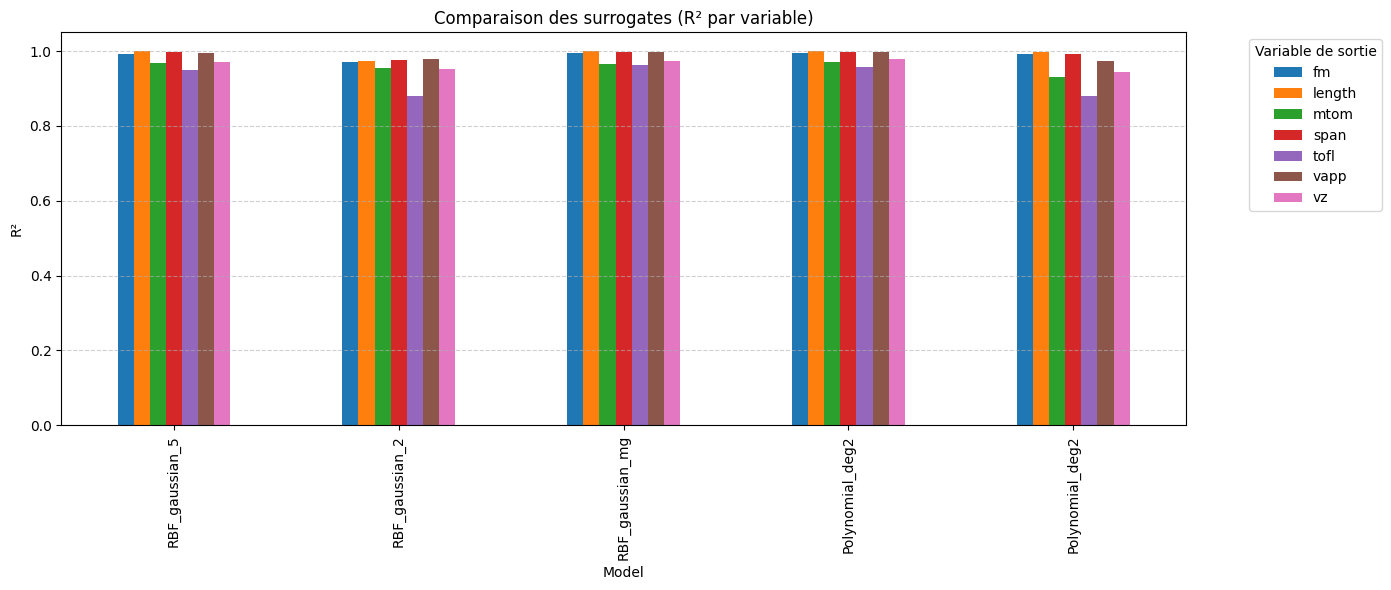

In [108]:
import pandas as pd
import matplotlib.pyplot as plt


# Liste des surrogates à tester avec leurs paramètres
surrogate_configs = [
    {"name": "RBF_gaussian_5", "model": "RBFRegressor", "function": "gaussian", "epsilon": 5},
    {"name": "RBF_gaussian_2", "model": "RBFRegressor", "function": "gaussian", "epsilon": 2},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric", "epsilon": 5},

    # {"name": "RBF_thinplate", "model": "RBFRegressor", "function": "thin_plate_spline", "epsilon": 2},
    # {"name": "Kriging_SE", "model": "Kriging", "correlation": "squared_exponential"},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 3},
    # {"name": "SVR_rbf", "model": "SVR", "function": "rbf", "C": 1.0, "epsilon": 0.1},
    # {"name": "RandomForest", "model": "RandomForest", "n_estimators": 100, "max_depth": 10},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    # Format results
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

# Créer un DataFrame pour affichage
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [109]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", function = "multiquadric", epsilon = 5, data = training_dataset)

# the optimum values computed by the optimization
# surrogate_discipline.execute({"slst": array([150.0]), "n_pax": array([150.0]), "area": array([180.0]), "ar": array([9.0])})

In [110]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)

{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [111]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.99378531]),
 'length': array([0.99982716]),
 'mtom': array([0.96629721]),
 'span': array([0.99778183]),
 'tofl': array([0.96239191]),
 'vapp': array([0.99704305]),
 'vz': array([0.9726315])}

In [112]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([3.38215141e-12]),
 'length': array([1.77856951e-12]),
 'mtom': array([4.43808225e-08]),
 'span': array([3.78990578e-11]),
 'tofl': array([3.27352386e-09]),
 'vapp': array([4.73346992e-11]),
 'vz': array([4.06570554e-11])}

In [113]:
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.08433618]),
 'length': array([0.06573397]),
 'mtom': array([1119.15181307]),
 'span': array([0.72314888]),
 'tofl': array([124.48634681]),
 'vapp': array([0.53798104]),
 'vz': array([1.34030018])}

In [115]:
from gemseo import from_pickle
# from gemseo import sample_disciplines
from gemseo import to_pickle

to_pickle(surrogate_discipline, "my_surrogate.pkl")
